In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


# Lets download the dataset

In [2]:
url='https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv'
df = pd.read_csv(url) # use sep="," for coma separation. 
print(df.head())

   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30       9/8/2016   
1           2             2     PAIDOFF       1000     30       9/8/2016   
2           3             3     PAIDOFF       1000     15       9/8/2016   
3           4             4     PAIDOFF       1000     30       9/9/2016   
4           6             6     PAIDOFF       1000     30       9/9/2016   

    due_date  age             education  Gender  
0  10/7/2016   45  High School or Below    male  
1  10/7/2016   33              Bechalor  female  
2  9/22/2016   27               college    male  
3  10/8/2016   28               college  female  
4  10/8/2016   29               college    male  


# Shape of the dataset

In [3]:
df.shape

(346, 10)

# Convert to date time object

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing¶


In [5]:
#Let’s see how many of each class is in our data set

df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection

In [6]:
# notice: installing seaborn might takes a few minutes
!pip install seaborn

# Lets plot some columns to underestand data better:

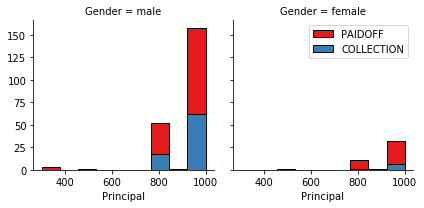

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

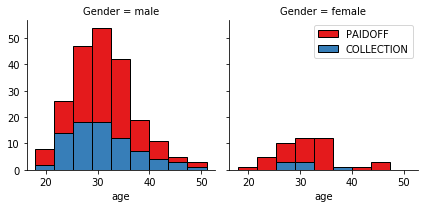

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()


# Pre-processing: Feature selection/extraction¶

Lets look at the day of the week people get the loan¶

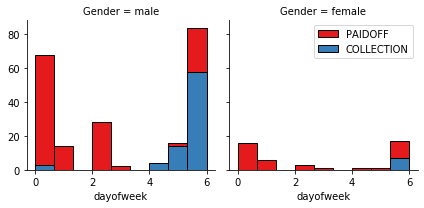

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


# Convert Categorical features to numerical values¶

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)


Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

 86 % of female pay there loans while only 73 % of males pay there loan

# Lets convert male to 0 and female to 1:

In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


# One Hot Encoding

How about education?¶


In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame¶


In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


# Feature selection¶

Lets defind feature sets, X:

In [16]:
X = Feature
X[0:5]


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Normalize Data¶

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification¶

1. K Nearest Neighbor(KNN)
2. Decision Tree
3. Support Vector Machine
4. Logistic Regression


# 1. K Nearest Neighbor(KNN)

warning: You should not use the loan_test.csv for finding the best k, however, you can split your train_loan.csv into train and test to find the best k.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [20]:
trainScores={}

In [21]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X_train) 
    kmeanModel.fit(X_train)     
      
    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X_train.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X_train, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X_train.shape[0] 
    mapping2[k] = kmeanModel.inertia_


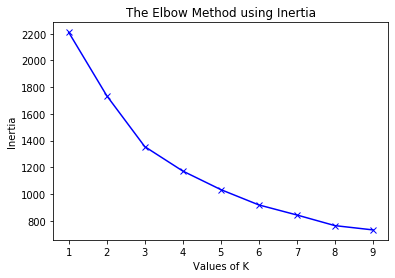

In [22]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [23]:
from sklearn.neighbors import KNeighborsClassifier
k=3
neigh=KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
knn_clf = neigh.predict(X_test)
knn_clf[0:5]
from sklearn import metrics
print("KNN train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("KNN test set Accuracy: ", metrics.accuracy_score(y_test, knn_clf))


KNN train set Accuracy:  0.8333333333333334
KNN test set Accuracy:  0.7142857142857143


In [24]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, knn_clf)

    
    std_acc[n-1]=np.std(knn_clf==y_test)/np.sqrt(knn_clf.shape[0])

mean_acc
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
#print('Train jaccard score :',jaccard_similarity_score(y_train, neigh.predict(X_train)))
print('KNN jaccard score :',jaccard_similarity_score(y_test, knn_clf))
print('KNN f1_score :',f1_score(y_test, knn_clf, average='weighted'))
#print('test log_loss :',log_loss(y_test, knn_clf,normalize=True))


KNN jaccard score : 0.7142857142857143
KNN f1_score : 0.7142857142857143


D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [25]:
trainScores['KNN Jaccard:']=jaccard_similarity_score(y_test, knn_clf)
trainScores['KNN f1_score:']=f1_score(y_test, knn_clf, average='weighted')

D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


# 2. Decision Tree¶

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
loan_status_tree=DecisionTreeClassifier(criterion="entropy", max_depth = 10)
loan_status_tree.fit(X_train,y_train)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [27]:
predTree =loan_status_tree.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])


['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [28]:
from sklearn import metrics
print("DecisionTrees train set Accuracy: ", metrics.accuracy_score(y_train, loan_status_tree.predict(X_train)))
print("DecisionTrees's test set Accuracy: ", metrics.accuracy_score(y_test, predTree))
print('test jaccard score :',jaccard_similarity_score(y_test, predTree))
print('test f1_score :',f1_score(y_test, predTree, average='weighted'))


DecisionTrees train set Accuracy:  0.8369565217391305
DecisionTrees's test set Accuracy:  0.7
test jaccard score : 0.7
test f1_score : 0.6765217391304347


D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [29]:
trainScores['DecisionTrees Jaccard:']=jaccard_similarity_score(y_test, predTree)
trainScores['DecisionTrees f1_score:']=f1_score(y_test, predTree, average='weighted')


D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [30]:
# pip install
!pip install pydotplus 
!pip install  python-graphviz

  ERROR: Could not find a version that satisfies the requirement python-graphviz (from versions: none)
ERROR: No matching distribution found for python-graphviz


from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline
dot_data = StringIO()
filename = "loan_status_tree.png"
featureNames = df.columns[3:-1]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loan_status_tree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 100))
plt.imshow(img,interpolation='nearest')




# 3. Support Vector Machine¶


In [31]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 


D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [32]:
yhat = clf.predict(X_test)
yhat [0:5]


array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[48  7]
 [11  4]]


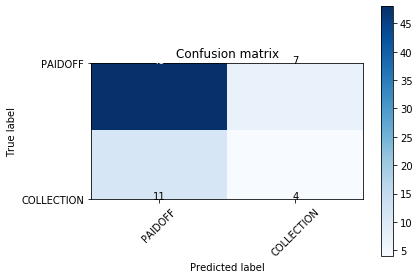

In [34]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')


In [35]:
print("SVM train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(X_train)))
print("SVM test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print('test jaccard score :',jaccard_similarity_score(y_test, yhat))
print('test f1_score :',f1_score(y_test, yhat, average='weighted'))


SVM train set Accuracy:  0.782608695652174
SVM test set Accuracy:  0.7428571428571429
test jaccard score : 0.7428571428571429
test f1_score : 0.7275882012724117


D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [36]:
trainScores['SVM Jaccard:']=jaccard_similarity_score(y_test, yhat)
trainScores['SVM f1_score:']=f1_score(y_test, yhat, average='weighted')

D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


# 4. Logistic Regression¶

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
yhat = LR.predict(X_test)
yhat[0:5]


array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [39]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob[0:5]


array([[0.5 , 0.5 ],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.34, 0.66],
       [0.32, 0.68]])

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION']))


[[46  9]
 [13  2]]


In [41]:
print("Logistic Regression training set Accuracy: ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("Logistic Regression test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print('test jaccard score :',jaccard_similarity_score(y_test, yhat))
print('test f1_score :',f1_score(y_test, yhat, average='weighted'))


Logistic Regression training set Accuracy:  0.7572463768115942
Logistic Regression test set Accuracy:  0.6857142857142857
test jaccard score : 0.6857142857142857
test f1_score : 0.6670522459996144


D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [42]:
trainScores['Logistic Regression Jaccard:']=jaccard_similarity_score(y_test, yhat)
trainScores['Logistic Regression f1_score:']=f1_score(y_test, yhat, average='weighted')

D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


# Model Evaluation using Test set¶


In [43]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

# Load Test set for evaluation¶

In [44]:
url='https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'
test_df  = pd.read_csv(url) # use sep="," for coma separation. 
print(test_df.head())

   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30       9/8/2016   
1           5             5     PAIDOFF        300      7       9/9/2016   
2          21            21     PAIDOFF       1000     30      9/10/2016   
3          24            24     PAIDOFF       1000     30      9/10/2016   
4          35            35     PAIDOFF        800     15      9/11/2016   

    due_date  age             education  Gender  
0  10/7/2016   50              Bechalor  female  
1  9/15/2016   35       Master or Above    male  
2  10/9/2016   43  High School or Below  female  
3  10/9/2016   26               college    male  
4  9/25/2016   29              Bechalor    male  


In [45]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df[0:5]
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df[0:5]

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [46]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df[0:5]
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df[0:5]


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [47]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df[0:5]

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [48]:
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

Feature[0:5]


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [49]:
X = Feature
y = test_df['loan_status'].values
y[0:5]


testy=y
testX= preprocessing.StandardScaler().fit(X).transform(X)


In [50]:
testScores={}


In [51]:
knn_pred=neigh.predict(testX)
testScores['KNN Jaccard:']=jaccard_similarity_score(testy,knn_pred)
testScores['KNN f1_score:']=f1_score(testy, knn_pred, average='weighted')

D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [52]:
Decision_Tree=loan_status_tree.predict(testX)
testScores['Decision Tree Jaccard:']=jaccard_similarity_score(testy, Decision_Tree)
testScores['Decision Tree f1_score:']=f1_score(testy, Decision_Tree, average='weighted')

D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [53]:
SVM=clf.predict(testX)
#SVM_proba=clf.predict_proba(testX)
LogisticRegression=LR.predict(testX)
testScores['SVM Jaccard:']=jaccard_similarity_score(testy, SVM)
testScores['SVM f1_score:']=f1_score(testy, SVM, average='weighted')
#testScores['SVM log_loss:']=log_loss(testy, SVM_proba)

D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [54]:
LogisticRegression=LR.predict(testX)
LogisticRegression_proba=LR.predict_proba(testX)
testScores['LogisticRegression Jaccard:']=jaccard_similarity_score(testy, LogisticRegression)
testScores['LogisticRegression f1_score:']=f1_score(testy, LogisticRegression, average='weighted')
testScores['LogisticRegression log_loss:']=log_loss(testy, LogisticRegression_proba)


D:\Users\shilp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [55]:
# Features used
list(Feature.columns)


['Principal',
 'terms',
 'age',
 'Gender',
 'weekend',
 'Bechalor',
 'High School or Below',
 'college']

In [56]:
trainScores

{'KNN Jaccard:': 0.7142857142857143,
 'KNN f1_score:': 0.7142857142857143,
 'DecisionTrees Jaccard:': 0.7,
 'DecisionTrees f1_score:': 0.6765217391304347,
 'SVM Jaccard:': 0.7428571428571429,
 'SVM f1_score:': 0.7275882012724117,
 'Logistic Regression Jaccard:': 0.6857142857142857,
 'Logistic Regression f1_score:': 0.6670522459996144}

In [57]:
testScores


{'KNN Jaccard:': 0.7037037037037037,
 'KNN f1_score:': 0.6736355806123249,
 'Decision Tree Jaccard:': 0.7407407407407407,
 'Decision Tree f1_score:': 0.7253086419753088,
 'SVM Jaccard:': 0.7962962962962963,
 'SVM f1_score:': 0.7583503077293734,
 'LogisticRegression Jaccard:': 0.7407407407407407,
 'LogisticRegression f1_score:': 0.6604267310789049,
 'LogisticRegression log_loss:': 0.5672153379912981}

# Report

The accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.7037  | 0.6736   | NA      |
| Decision Tree      | 0.7407  | 0.7253   | NA      |
| SVM                | 0.7962  | 0.7583	  | NA      |
| LogisticRegression | 0.7407  | 0.6604   | 0.5672  |